# Lab 09: RNNs

Some references for the materials used for this lab:
- https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks
- https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn

Today we'll do some preliminary investigation of simple RNNs similar to the form of Figure 10.3 in Goodfellow et al. (the Elman network).


## Recurrent neural networks (RNNs)

**Recurrent neural networks** or **RNNs** are a class of neural networks that build up hidden state over time, using previous inputs, previous outputs, and/or previous hidden states to be used as inputs to the calculation at the current point in time. RNNs work on the principle of saving the output of a particular layer and feeding this back to the network as an input.

This diagram gives the idea of one of the simplest types of recurrent networks, the Elman network:

<img src="img/rnns_unfold2.PNG" title="RNNs" style="width: 600px;" />

Mathematically, for each timestep $t$, the activation $a^{(t)}$ and the output $y^{(t)}$ are expressed as
$$\begin{eqnarray} a^{(t)} & = & g_1(W_{aa}a^{(t-1)}+W_{ax}x^{(t)} + b_a) \\
y^{(t)} & = & g_2(W_{ya}a^{(t)} + b_y), \end{eqnarray}$$

where $W_{ax}, W_{aa}, W_{ya}, b_a, b_y$ are coefficients that are shared temporally and $g_1, g_2$ are activation functions.

Advantages and disadvantages of RNNs:

| Advantages                                              | Disadvantages                                          |
|:--------------------------------------------------------|:-------------------------------------------------------|
| Possibility of processing input of any length           | Slow sequential computation                            |
| Model size fixed regardless of input length             | Difficult to preserve information from a long time ago |
| Computation accumulates historical information          | Current state cannot be conditioned on future input    |
| Weight sharing across time gives statistical efficiency |                                                        |

### Applications of RNNs

RNN models are mostly used in the fields of natural language processing and speech recognition. Each type of RNN is applicable to different situations.
Some typical RNNs:

<img src="img/rnns_example2.png" title="RNNs" style="width: 800px;" />

Here are some example applications of these different types of models:

| RNN Type | Example Application|
|:--|:--|
| One-to-One                  | Control                  |
| One-to-Many                 | Music generation         |
| Many-to-One                 | Sentiment classification |
| Many-to-Many $T_x \neq T_y$ | Machine translation      |
| Many-to-Many $T_x = T_y$    | Name entity recognition  |

### Loss function and back propagation

In the case of a recurrent neural network, the loss function $\mathcal{L}$ over all time steps is defined based on the loss at each time step:

$$\mathcal{L}(\hat{y}, y) = \sum_{t=1}^{T_y}\mathcal{L}(\hat{y}^{(t)}, y^{(t)})$$

The backpropagation calculation can therefore be broken up into individual time-synchronized calculations.
At timestep $t$, the derivative of the loss $\mathcal{L}$ with respect to weight matrix $W$ is

$$\frac{\partial\mathcal{L}^{(t)}}{\partial W} = \sum_{t=1}^T \frac{\partial\mathcal{L}^{(t)}}{\partial W} |_{(t)}$$

### Popular activation functions

The most common activation functions:

- Sigmoid (Bernoulli output)
- Softmax (multinomial output)
- Tanh (hidden state)
- ReLU (hidden states in deeper RNNs)

## Predicting the language a surname comes from

Let's begin with one of the official PyTorch tutorials on [classifying surnames from 18 languages based on the character sequence](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

## Runtime environment

For the runtime environment, we won't get much benefit from the GPU in today's lab, as the examples are not batched, and it's not easy to do so, since different words have different lengths. Since the GPU server isn't going to help us much, you may prefer to run locally using Jupyter.

## Surnames dataset

Get your Jupyter environment up and running, then download the dataset (https://download.pytorch.org/tutorial/data.zip) and unzip it in your project directory.

Here's code directly from the tutorial to read the names into a dictionary of the form { language1: [name1, name2, ...], language2: ... }

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

[]


In [3]:
n_letters

57

In [4]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [7]:
# Build the category_lines dictionary, a list of names per language

category_lines = {}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# Check that it worked

for c in all_categories[:2]:
    print(c)
    # print(category_lines[c]) 

Dutch
Korean


OK, try it out. You can see some results with a query like

In [8]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Text embedding

*Embedding* refers to the process of turning complex structured or unstructured data into a real-valued vector form suitable for deep learning.
There are many different ways of representing text in deep learning. Examples:

- One-hot encoding
- Global Vector for word representation (GloVe)
- Bag-of-words (BOW)
- n-grams

Today we'll use the most basic of these algorithms, one-hot encoding.

## One-hot encoding (what is it?)

This information is from [Victor Zhou's blog on one-hot encoding](https://victorzhou.com/blog/one-hot/).

One-hot encoding maps a single integer to a vector in which
a single element is 1 and all other elements are 0, such as $[0, 1, 0, 0]$.
This is also known as integer encoding. To interpret or generate a sequence of
characters, we assign a unique one-hot code to each element in our vocabulary:

|Character|Value|One-Hot|
|---------|-----|-------|
|A|1|1 0 0 0 ...|
|B|2|0 1 0 0 ...|
|C|3|0 0 1 0 ...|

The representation is useful not only for characters, but any discrete tokens, especially
words (when the vocabulary is not too large):

|Word|Value|One-Hot|
|---------|-----|-------|
|Red|1|1 0 0 0 ...|
|Blue|2|0 1 0 0 ...|
|Green|3|0 0 1 0 ...|

One benefit of a one-hot encoding of a sequence of tokens is that you can easily convert the sequence into
a "bag of words" representation in which each element represents the (possibly weighted) frequency of a
term over the sequence. To get unweighted frequencies, just add your one-hot vectors along the time dimension.

## One-hot representation of characters

Next, let's see how to convert each letter in a word to a sequence of one-hot representations, for example mapping the character `b` tot he vector $[0 1 0 0 0 ...]$.
The tensor size will be `linelength` $\times$ 1 $\times$ `nletters`. The first dimension is the number of characters in a given word/line of a data file,
the second dimension is the index into the batch (we have a batch size of 1 here), and the third dimension indexes the different characters in the vocabulary.

There are many ways to do it. Scikit-learn has functionality to perform one-hot encoding for an arbitrary dictionary:

In [10]:
# One-hot encoding of a word vocabulary using scikit-learn’s OneHotEncoder

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
print(encoder.fit_transform([['red'], ['green'], ['blue']]))

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


And here's a simple method to encode a sequence of integers using numpy:

In [11]:
# One-hot encoding of a word using numpy

import numpy as np

arr = [2, 1, 0]
max = np.max(arr) + 1
print(np.eye(max)[arr])

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


Here's PyTorch code for the same process:

In [12]:
import torch

# Find letter index from all_letters, e.g. "a" -> 0

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## The RNN

Next, let's implement the RNN structure itself:

<img src="img/rnns_code2.png" title="RNNs" style="width: 400px;" />

In [82]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.tanh(hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, size):
        return torch.zeros(size, self.hidden_size)

n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)

A quick inspection shows that this only implements one time step for the model.
The forward function takes an input and a previous hidden state, returning
the output and the new hidden state.

Note that this model is different from the Elman network structure in that the output layer takes
input directly from the input as well as from the hidden layer.

Here's code to pass an 'A' to our model, with the initial hidden state
fixed to all zeros:

In [60]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
output

tensor([[-2.7612, -3.0033, -2.9817, -2.9763, -2.8095, -2.8795, -2.8467, -2.7482,
         -2.9502, -2.9319, -2.8476, -2.8870, -2.9194, -2.9353, -2.9570, -2.8876,
         -2.9300, -2.8220]], grad_fn=<LogSoftmaxBackward0>)

*Why don't the numbers add up to 1.0 if it's a softmax output?*
Take a look a the code and figure it out.

You can try `lineToTensor()` instead of `letterToTensor()`
and run through an entire name such as 'Albert'.

In [83]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

next_hidden = hidden
for i in range(input.shape[0]):
    output, next_hidden = rnn(input[i], next_hidden)
    print(output)

tensor([[-2.8793, -2.9922, -2.8066, -2.8004, -2.9796, -2.9648, -2.8965, -2.9250,
         -2.8924, -2.8242, -2.8346, -2.9655, -2.9760, -2.7306, -3.0058, -2.9326,
         -2.8485, -2.8260]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.8775, -2.9998, -2.8489, -2.7343, -2.9938, -2.9691, -2.8407, -2.9393,
         -2.8540, -2.8068, -2.8194, -2.9074, -2.9486, -2.8126, -2.9662, -2.9917,
         -2.9020, -2.8645]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.8405, -2.9871, -2.7961, -2.7752, -2.9660, -2.9724, -2.8550, -2.9612,
         -2.8740, -2.8447, -2.8171, -2.9285, -2.9628, -2.8055, -2.9581, -2.9469,
         -2.9318, -2.8470]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.8630, -2.9901, -2.8213, -2.8330, -3.0079, -2.9134, -2.8605, -2.9707,
         -2.8805, -2.8506, -2.7833, -2.9112, -2.9892, -2.7413, -2.9883, -2.9628,
         -2.9257, -2.7901]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.8755, -2.9262, -2.8790, -2.7913, -2.9169, -2.9633, -2.8439, -2.9426,
         -2.8344, -2.8153, -2.7

### Training

To get started with training, we need some helper functions.
This one converts an output vector to a category:

In [84]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 3)


Next, let's add a function to get a random element of our training set:

In [85]:
import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', c)

category = Russian / line = Korean
category = Arabic / line = Korean
category = German / line = Korean
category = English / line = Korean
category = Korean / line = Korean
category = Czech / line = Korean
category = Polish / line = Korean
category = Italian / line = Korean
category = German / line = Korean
category = Russian / line = Korean


For the loss function, let's use negative log likelihood:

In [86]:
criterion = nn.NLLLoss() 

Then a function for training on one sequence:

In [87]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden(batch_size)

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(- learning_rate * p.grad.data)

    return output, loss.item()  

Try running it for a few iterations on a single random pattern.

Next, try this code for the overall training:

In [88]:
import time
import math

n_iters = 300000
print_every = 300
plot_every = 1000
batch_size = 32

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, int((n_iters + 1)/batch_size)):
    labels, minibatch_line_tensors = random_build_mini_batch(batch_size)
    output, loss = train(labels, minibatch_line_tensors)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / (n_iters/batch_size) * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

300 3% (0m 2s) 2.9136 Hamatnurov / French ✗ (Russian)
600 6% (0m 4s) 2.8793 Hamatnurov / French ✗ (Russian)
900 9% (0m 7s) 2.8942 Hamatnurov / French ✗ (Russian)
1200 12% (0m 10s) 2.8821 Hamatnurov / French ✗ (Russian)
1500 16% (0m 12s) 2.8873 Hamatnurov / French ✗ (Russian)
1800 19% (0m 15s) 2.8902 Hamatnurov / French ✗ (Russian)
2100 22% (0m 17s) 2.8758 Hamatnurov / Greek ✗ (Russian)
2400 25% (0m 19s) 2.8795 Hamatnurov / French ✗ (Russian)
2700 28% (0m 22s) 2.8833 Hamatnurov / French ✗ (Russian)
3000 32% (0m 24s) 2.8679 Hamatnurov / Spanish ✗ (Russian)
3300 35% (0m 27s) 2.8740 Hamatnurov / Chinese ✗ (Russian)
3600 38% (0m 29s) 2.8793 Hamatnurov / Chinese ✗ (Russian)
3900 41% (0m 31s) 2.8405 Hamatnurov / Chinese ✗ (Russian)
4200 44% (0m 33s) 2.6788 Hamatnurov / Greek ✗ (Russian)
4500 48% (0m 36s) 2.5999 Hamatnurov / Greek ✗ (Russian)
4800 51% (0m 38s) 2.6338 Hamatnurov / Greek ✗ (Russian)
5100 54% (0m 41s) 2.3566 Hamatnurov / Greek ✗ (Russian)
5400 57% (0m 43s) 2.4659 Hamatnurov / Por

 Finally, plot the resulting training loss:
 

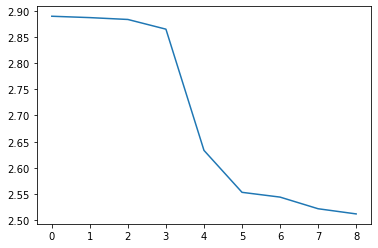

In [89]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Evaluation

Great, we have a trained model. Let's get a confusion matrix:

/tmp/ipykernel_4399/1786284385.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_4399/1786284385.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


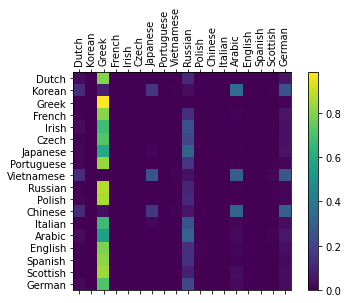

In [90]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden(1)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Take a look at the most likely confusions and see if they make sense.

### Prediction on user input

Finally, try classifying novel inputs:

In [91]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.59) Greek
(-2.11) Russian
(-2.51) Polish

> Jackson
(-1.87) Greek
(-2.26) Russian
(-2.56) Polish

> Satoshi
(-1.92) Greek
(-2.21) Russian
(-2.44) Polish


### Exercises

Try the following:

1. Change the structure to be identical to Goodfellow's Figure 10.3 (no input-to-hidden connection) with tanh activation functions
   and see if you get different results.
   
2. Explore methods for batching patterns of different length prior to presentation to a RNN and
   implement them. See how much speedup you can get from the GPU with minibatch training.

3. Do a bit of research on similar problems such as named entity recognition, find a dataset,
   train a model, and report your results.

### The report

As always, your report is due next week. Please submit via Google Classroom.

1. Change the structure to be identical to Goodfellow's Figure 10.3 (no input-to-hidden connection) with tanh activation functions
   and see if you get different results.

   Result  
   <code>
    class RNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(RNN, self).__init__()

            self.hidden_size = hidden_size
            
            self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
            self.h2o = nn.Linear(hidden_size, output_size)
            self.tanh = nn.Tanh()
            self.softmax = nn.LogSoftmax(dim=1)

        def forward(self, input, hidden):
            combined = torch.cat((input, hidden), 1)
            hidden = self.i2h(combined)
            hidden = self.tanh(hidden)
            output = self.h2o(hidden)
            output = self.softmax(output)
            return output, hidden

        def initHidden(self):
            return torch.zeros(1, self.hidden_size)

    n_hidden = 128
    rnn = RNN(n_letters, n_hidden, n_categories)
   </code>

   Instead of the previous rnn model which have i2o and i2h layer, this model change to input-to-hidden and hidden-to-output. After the input pass through the input-to-hidden layer, the model have Tanh activation function. After activation function we will get the hidden output. Then we use the hidden vector pass through hidden-to-output layer to get output vector. After that, the model apply softmax to output vector.

   This is the confusion matrix with previous rnn model.  
   <img src="reportImg/beforeChangeTonewRNN.png" title="RNNs" style="width: 500px;" />

   Confusion matrix after update rnn model  
   <img src="reportImg/AfterUpdateRnn.png" title="RNNs" style="width: 500px;" />  

   As we can see, the RNN model according to Goodfellow's Figure 10.3 get better target prediction result.


2. Explore methods for batching patterns of different length prior to presentation to a RNN and
   implement them. See how much speedup you can get from the GPU with minibatch training.

   In order to create minibatch using words which have difference length, we need to add padding to shorter word to make every word have same length.